# Homework 5

## Task 1 (70 points):

### Part 1 (20 points): 
This step involves downloading, preparing, and visualizing your
dataset. Create a convolutional base using a common pattern: a stack of Conv and
MaxPooling layers. Depending on the problem and the dataset you must decide what
pattern you want to use (i.e., how many Conv layers and how many pooling layers).
Please describe why you chose a particular pattern. Add the final dense layer(s).
Compile and train the model. Report the final evaluation and describe the metrics.

In [20]:
# dataset: https://www.kaggle.com/datasets/zalando-research/fashionmnist


from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, ReLU, Add, AveragePooling2D
from tensorflow.keras.regularizers import L2
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

folder_name = "./fashionmnist"
file_name = "fashion-mnist_train.csv"


if not os.path.exists(folder_name):
    import opendatasets as od
    # download the data
    dataset_link = "https://www.kaggle.com/datasets/zalando-research/fashionmnist"
    od.download(dataset_link)

data = pd.read_csv(os.path.join(folder_name, file_name))
y = data['label']
x = data.drop('label', axis=1)
x.head()
x = x.to_numpy().reshape((-1, 28,28,1))
y = y.to_numpy()

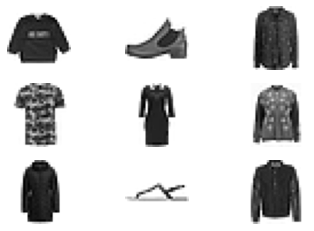

In [21]:
# visualize the data
for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.axis('off')
    plt.imshow(255 - x[i], cmap='gray')
    
plt.show()

In [22]:
def expand_one_hot(number, nums):
    out = np.zeros((nums,))
    out[number] = 1
    return out

def one_hot_encode(a):
    mapping = {}
    index = 0
    for item in a:
        if item not in mapping:
            mapping[item] = index
            index += 1


    out = np.zeros((len(a), index))

    for i, item in enumerate(a):
        out[i] = expand_one_hot(mapping[item], index)

    return out

y = one_hot_encode(y)

In [23]:
split_train = 0.7
split_dev = 0.2
split_index_train = int(len(x) * split_train)
split_index_dev = int(len(x) * (split_train + split_dev))

order = np.arange(len(x))
np.random.shuffle(order)
x[order] = x
y[order] = y

x_train, y_train = x[:split_index_train], y[:split_index_train]
x_dev, y_dev = x[split_index_train:split_index_dev], y[split_index_train:split_index_dev]
x_test, y_test = x[split_index_dev:], y[split_index_dev:]

mu_x = np.mean(x_train)
std_x = np.std(x_train)

x_train = (x_train - mu_x) / std_x
x_dev = (x_dev - mu_x) / std_x
x_test = (x_test - mu_x) / std_x

In [24]:
def get_model(inpt_shape, classes, regularizer):
    inpt = Input(inpt_shape)
    x = Conv2D(128, 5, 2, kernel_initializer="he_uniform", kernel_regularizer=regularizer)(inpt)
    x = ReLU()(x)
    x = MaxPool2D()(x)
    x = Conv2D(256, 3, kernel_initializer="he_uniform", kernel_regularizer=regularizer)(x)
    x = ReLU()(x)
    x = MaxPool2D(3)(x)
    x = Flatten()(x)
    x = Dense(classes, activation="softmax", kernel_initializer="glorot_uniform", kernel_regularizer=regularizer)(x)
    model = Model(inputs=inpt, outputs=x)
    return model

model = get_model(x_train.shape[1:], y_train.shape[1], L2(0.01))
model.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       3328      
                                                                 
 re_lu_102 (ReLU)            (None, 12, 12, 128)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 re_lu_103 (ReLU)            (None, 4, 4, 256)         0         
                                                           

In [25]:
def make_plot(history, loc):
    plot = plt.plot(
        np.array([history[item] for item in loc]).T
    )
    plt.legend(plot, loc, loc=1)
    plt.show()

Epoch 1/20
1313/1313 [==============================] - 17s 12ms/step - loss: 2.4932 - accuracy: 0.7833 - val_loss: 0.9474 - val_accuracy: 0.7994
Epoch 2/20
1313/1313 [==============================] - 15s 11ms/step - loss: 0.8935 - accuracy: 0.7976 - val_loss: 0.8734 - val_accuracy: 0.8002
Epoch 3/20
1313/1313 [==============================] - 14s 11ms/step - loss: 0.8570 - accuracy: 0.8018 - val_loss: 0.8360 - val_accuracy: 0.8077
Epoch 4/20
1313/1313 [==============================] - 15s 11ms/step - loss: 0.8404 - accuracy: 0.8038 - val_loss: 0.8206 - val_accuracy: 0.8119
Epoch 5/20
1313/1313 [==============================] - 15s 11ms/step - loss: 0.8285 - accuracy: 0.8079 - val_loss: 0.8195 - val_accuracy: 0.8164
Epoch 6/20
1313/1313 [==============================] - 14s 11ms/step - loss: 0.8228 - accuracy: 0.8067 - val_loss: 0.8102 - val_accuracy: 0.8153
Epoch 7/20
1313/1313 [==============================] - 14s 11ms/step - loss: 0.8176 - accuracy: 0.8098 - val_loss: 0.8266 -

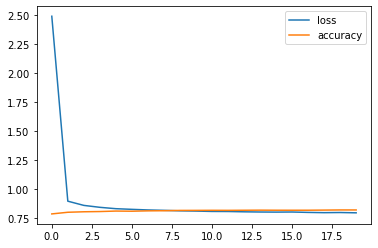

In [26]:
epochs = 20

history = model.fit(x_train, y_train, validation_data=(x_dev, y_dev), epochs=epochs)
make_plot(history.history, ['loss', 'accuracy'])

In [27]:
print("evaluation on test set: {{\n\t loss: {:.5f}, accuracy: {:.5f}\n}}".format(*model.evaluate(x_test, y_test, verbose=0)))

evaluation on test set: {
	 loss: 0.77382, accuracy: 0.82636
}


### Part 2 (25 points): 
The following models are widely used for transfer learning because of
their performance and architectural innovations:
 -  VGG (e.g., VGG16 or VGG19).
 -  GoogLeNet (e.g., InceptionV3).
 -  Residual Network (e.g., ResNet50).
 -  MobileNet (e.g., MobileNetV2)
Choose any one of the above models to perform the classification task you did in Part 1.
Evaluate the results using the same metrics as in Part 1. Are there any differences? Why
or why not?

Epoch 1/5
1313/1313 [==============================] - 1212s 917ms/step - loss: 0.6981 - accuracy: 0.8197 - val_loss: 2.3912 - val_accuracy: 0.0988
Epoch 2/5
1313/1313 [==============================] - 1346s 1s/step - loss: 0.3309 - accuracy: 0.9007 - val_loss: 2.4828 - val_accuracy: 0.0991
Epoch 3/5
1313/1313 [==============================] - 1270s 967ms/step - loss: 0.2752 - accuracy: 0.9202 - val_loss: 2.9006 - val_accuracy: 0.1001
Epoch 4/5
1313/1313 [==============================] - 1261s 960ms/step - loss: 0.2296 - accuracy: 0.9339 - val_loss: 6.7662 - val_accuracy: 0.0987
Epoch 5/5
1313/1313 [==============================] - 1258s 958ms/step - loss: 0.1958 - accuracy: 0.9462 - val_loss: 4.0446 - val_accuracy: 0.0987


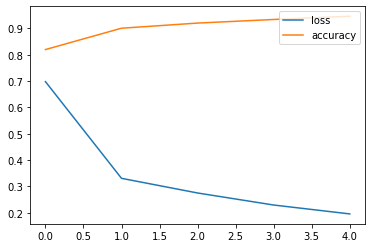

In [28]:
from tensorflow.keras.applications import VGG16
# from tensorflow.keras.layers import ZeroPadding2D, Reshape
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.applications import MobileNetV3Small

def get_transfer_model(inpt_shape, classes, regularizer):
    inpt = Input(inpt_shape)

    x = Conv2DTranspose(3, 3, strides=8)(inpt)
    transfer = MobileNetV3Small(include_top=False, weights="imagenet", input_tensor=x)
    
    x = transfer.output
    x = Flatten()(x)
    x = Dense(classes, activation="softmax", kernel_initializer="glorot_uniform", kernel_regularizer=regularizer)(x)
    model = Model(inputs=inpt, outputs=x)
    return model

transfer_model = get_transfer_model(x_train.shape[1:], y_train.shape[1], L2(0.01))
transfer_model.compile(loss="categorical_crossentropy", metrics=['accuracy'])


epochs = 5

history = transfer_model.fit(x_train, y_train, validation_data=(x_dev, y_dev), epochs=epochs)
make_plot(history.history, ['loss', 'accuracy'])

In [30]:
print("evaluation on test set: {\n\tloss: {:.5f}, accuracy: {:.5f}\n}".format(*transfer_model.evaluate(x_test, y_test, verbose=0)))

NameError: name 'transfer_model' is not defined

In [29]:
del model
del transfer_model

### Part 3 (25 points): 
Use data augmentation to increase the diversity of your dataset by
applying random transformations such as image rotation (you can use any other
technique as well). Repeat the process from part 1 with this augmented data. Did you
observe any difference in results?

In [40]:
def add_transformation(x, y, x_prime):
    return np.concatenate((x,x_prime)), np.concatenate((y,y.copy()))

def augment(inpt_data_set):
    x, y = inpt_data_set

    # rotate images
    x_rotate = np.rot90(x, axes=(1,2))
    x, y = add_transformation(x, y, x_rotate)
    print(x.shape)
    print(y.shape)

    # flip up down
    x_flipud = np.flipud(x)
    x, y = add_transformation(x, y,  x_flipud)

    # flip left right
    x_fliplr = np.fliplr(x)
    return add_transformation(x, y, x_fliplr)

augmented_ds = augment((x_train, y_train))
original_model = get_model(x_train.shape[1:], y_train.shape[1], L2(0.01))
original_model.compile(Adam(0.01), loss="categorical_crossentropy", metrics=['accuracy'])

epochs = 20
history = original_model.fit(*augmented_ds, validation_data=(x_dev, y_dev), epochs=epochs)
make_plot(history.history, ['loss', 'accuracy'])

(84000, 28, 28, 1)
(84000, 10)


In [ ]:
print("evaluation on test set: {\n\tloss: {:.5f}, accuracy: {:.5f}\n}".format(*original_model.evaluate(x_test, y_test, verbose=0)))

## Task 2 (30 points):

### Part 1 (15 points): 

Variational Autoencoder (VAE): Here is a complete implementation
of a VAE in TensorFlow: https://www.tensorflow.org/tutorials/generative/cvae
Following these steps try generating images using the same encoder-decoder architecture using
a different Image dataset (other than MNIST).

In [35]:
class CVAE(tf.keras.Model):

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits
  optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

optimizer = tf.keras.optimizers.Adam(1e-4)

In [37]:
epochs = 10
latent_dim = 20

model = CVAE(latent_dim)

for epoch in range(1, epochs + 1):
  for train_x in x_train:
    train_step(model, train_x, optimizer)

  loss = tf.keras.metrics.Mean()
  for test_x in x_train:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {},'.format(epoch, elbo))

In [ ]:
mean, logvar = model.encode(x_test)
z = model.reparameterize(mean, logvar)
predictions = model.sample(z)[0]
plt.imshow(255 - predictions[0, :, :, 0], cmap='gray')

### Part 2 (15 points): 
Generative Adversarial Networks (GANs): Repeat part 1 (use same
dataset) and implement a GAN m/odel to generate high quality synthetic images. You may
follow steps outlined here: https://www.tensorflow.org/tutorials/generative/dcgan

In [31]:
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Reshape
from tensorflow.keras.optimizers import RMSprop

REAL_LABEL = 1
FAKE_LABEL = 0

# y should be -1 if fake and 1 if real
def wgan_loss(y_true, y_pred):
    # 1/m sum(f(x)) - 1/m sum(f(g(z)))
    # = 1/m sum(f(x) - f(g(z)))
    # = 1/m sum(f(all) * label) bc the -1 will negate the fake ones
    loss = tf.reduce_sum(y_true * y_pred)
    return loss

# if the signs are the same the output is correct
def wgan_acc(y_true, y_pred):
    return (1 + -tf.reduce_mean(tf.multiply(tf.sign(y_true), tf.sign(y_pred)))) / 2


def get_generator(img_shape, latent_dim):
    inpt = Input((latent_dim,))
    upscale_n = 7 * 7 * 128 # assumes channel of img shape = 1
    
    x = Dense(upscale_n)(inpt)
    x = ReLU()(x)
    x = Reshape((7, 7, 128))(x)
    x = Conv2DTranspose(128, 4, 2, padding='same')(x)
    x = ReLU()(x)
    x = Conv2DTranspose(128, 4, 2, padding='same')(x)
    x = ReLU()(x)

    x = Conv2D(1, (7,7), activation='tanh', padding='same')(x)
    return Model(inputs=inpt, outputs=x)

# based on the wasserstein gan model thus the linear output
def get_discriminator(img_shape, clip_value):
    inpt = Input(img_shape)

    x = Conv2D(32, 5, 2, kernel_constraint=max_norm(clip_value))(inpt)
    x = ReLU()(x)
    x = MaxPool2D()(x)
    x = Conv2D(64, 3, 1, kernel_constraint=max_norm(clip_value))(x)
    x = ReLU()(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(128, kernel_constraint=max_norm(clip_value))(x)
    # predicts any real valued output
    # x = Dense(1, kernel_constraint=max_norm(clip_value))(x)
    x = Dense(1, activation="sigmoid")(x)
    return Model(inputs=inpt, outputs=x)

def get_gan(img_shape, latent_dim, clip_value, lr):
    generator = get_generator(img_shape, latent_dim)
    discriminator = get_discriminator(img_shape, clip_value)
    # discriminator.compile(RMSprop(learning_rate=lr), loss=wgan_loss, metrics=[wgan_acc])
    discriminator.compile(Adam(learning_rate=lr), loss=wgan_loss, metrics=[wgan_acc])
    discriminator.trainable = False
    output = discriminator(generator.output)
    gan = Model(inputs=generator.input, outputs=output)
    gan.compile(RMSprop(learning_rate=lr), loss=wgan_loss, metrics=[wgan_acc])
    gan.compile(RMSprop(learning_rate=lr), loss=wgan_loss, metrics=[wgan_acc])
    return generator, discriminator, gan
    

generator, discriminator, gan = get_gan(x_train.shape[1:], 100, 1, 0.01)

In [32]:
def generate_noise(batch_size, latent_dim):
    return tf.random.normal([batch_size, latent_dim])

def generate_labels(label, batch_size):
    return label * tf.ones((batch_size, 1))

def merge_shuffle_batch(real, fake):
        real_Y, fake_Y = (
            generate_labels(REAL_LABEL, len(real)), 
            generate_labels(FAKE_LABEL, len(fake))
        )
        X = np.concatenate((real, fake))
        Y = np.concatenate((real_Y, fake_Y))
        order = np.arange(len(real) + len(fake))
        np.random.shuffle(order)
        Y = Y[order]
        X = X[order]
        return X, Y

In [33]:
epochs = 10
batch_size = 64
critic_iters = 1
gen_iters = 0

num_batches = x_train.shape[0] // batch_size 

for epoch in range(epochs):
    batch_index = 0
    print("starting epoch", epoch)
    while batch_index < num_batches:
            print("batch {}/{}\r".format(batch_index, num_batches))

            c_critic_iters = critic_iters
            # if gen_iters < 5 or gen_iters % 500 == 0:
            #     # c_critic_iters = 100

            for _ in range(c_critic_iters):
                if batch_index >= num_batches:
                    break
                batch_index += 1

                real_X = x_train[batch_size * batch_index: batch_size * (batch_index + 1)]
                

                noise =  generate_noise(batch_size, 100)
                fake_X = generator(noise) 


                X, Y = merge_shuffle_batch(
                    real_X, 
                    fake_X
                )

                discriminator.train_on_batch(X, Y)


            labels = generate_labels(REAL_LABEL, batch_size)
            
            noise = generate_noise(batch_size, 100)

            gan.train_on_batch(noise, labels)
            gen_iters += 1


starting epoch 0
batch 0/656
batch 1/656
batch 2/656
batch 3/656
batch 4/656
batch 5/656
batch 6/656
batch 7/656
batch 8/656
batch 9/656
batch 10/656
batch 11/656
batch 12/656
batch 13/656
batch 14/656
batch 15/656
batch 16/656
batch 17/656
batch 18/656
batch 19/656
batch 20/656
batch 21/656
batch 22/656
batch 23/656
batch 24/656
batch 25/656
batch 26/656
batch 27/656
batch 28/656
batch 29/656
batch 30/656
batch 31/656
batch 32/656
batch 33/656
batch 34/656
batch 35/656
batch 36/656
batch 37/656
batch 38/656
batch 39/656
batch 40/656
batch 41/656
batch 42/656
batch 43/656
batch 44/656
batch 45/656
batch 46/656
batch 47/656
batch 48/656
batch 49/656
batch 50/656
batch 51/656
batch 52/656
batch 53/656
batch 54/656
batch 55/656
batch 56/656
batch 57/656
batch 58/656
batch 59/656
batch 60/656
batch 61/656
batch 62/656
batch 63/656
batch 64/656
batch 65/656
batch 66/656
batch 67/656
batch 68/656
batch 69/656
batch 70/656
batch 71/656
batch 72/656
batch 73/656
batch 74/656
batch 75/656
batch

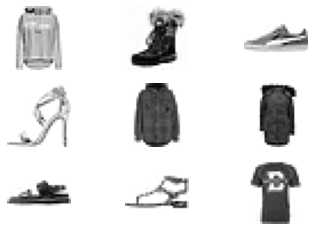

In [34]:
# generate samples
noise = generate_noise(9, 100)
synthesized = generator(noise)


# visualize the data
for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.axis('off')
    plt.imshow(255 - synthesized[i], cmap='gray')
    
plt.show()

## Project Progress Report (This is not graded)
Please submit a report detailing your progress on the final project. This can be a 1 (maximum 2)
page long description of your data-collection/modelling/preliminary results related tasks. Also,
describe the next steps towards your final goal.

My project does not have a dataset as it is an RL project. Instead I have created the environment for the RL agent complete with observations and rewards. Currently I am working on the framework to implement this model allowing for the use of experience replay. The RL algorithm I will most likely implement will be PPO (proximal policy optimization) as I have discrete action and observation spaces. In order to get this baseline working, I will need to complete the action space output of the environment as well as allowing for multiple agents to learn in parallel. 